# Piotroski F-Score for Stock Selection
by Chee-Foong（曾志峰）from Singapore（新加坡）on 5 Aug 2020


## Summary
This notebook calculates the Piotroski F-Score of all companies in the CSI 300 (沪深300) Index.  The score is a number between 0 and 9.  Assessing the financial strength of the companies for identifying value stocks.

Let me know whether such 

## Calculation
Add 1 to the score if any of the below statements is true

**Profitability (公司盈利项)** - *Is the company making money?*
- Return of Asset is positive (资产收益率是否为正?)
- Operating Cash Flow is positive (经营现金流是否为正?)
- Change in ROA is positive (去年的资产回报率是否增长了?)
- OCF/TA is larger than ROA (产生的现金流量比利润好吗?)

**Leverage and Source of Funds (债务项)** - *How much of the funds are from debt?*
- Change in Leverage Ratio (Long-Term Debt) is negative (过去一年杠杆率下降了吗?)
- Change in Current Ratio is positive (过去一年资产负债的流动比率是否有所提高(即手上持有的现金是否更多)?)
- No increase in number of existing shares (公司有发行股票吗?)

**Operating Efficiency** - *Is the company generating profits from its assets efficiently?*
- Change in Gross Margin is positive (过去一年的毛利率增长了吗?)
- Change in Asset Turnover is positive (去年的资产周转率是否增长了?)


## References
1. https://www.zhitongcaijing.com/content/detail/316953.html (华文)
2. https://codingandfun.com/piotroski-f-score/
3. https://en.wikipedia.org/wiki/Piotroski_F-score 

## Import Libraries

In [1]:
import time
import re
import random
import numpy as np
import pandas as pd

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

## Changing the default settings
pd.options.display.max_columns = 50
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [2]:
def getSymbolName(symbol):
    info = security_list.loc[symbol]
    return info.display_name, info.stock_name

### Loading data

#### Security Information

In [3]:
security_list = pd.read_csv('../data/security_list.csv')
security_list.set_index('symbol', inplace=True)

#### Security Prices

In [4]:
prices = pd.read_csv('../data/security_prices.csv')
prices.date = pd.to_datetime(prices.date)
prices.set_index('date', inplace=True)

#### Factors

In [5]:
factor_data = pd.read_csv('../data/factor_data.csv')
factor_data.date = pd.to_datetime(factor_data.date)
factor_data.set_index(['date','factor'], inplace=True)

Filtering data between 2005 to 2020

In [6]:
idx = pd.IndexSlice
factor_data_reduced = factor_data.loc[idx['2005':'2020',:],:]

In [7]:
factor_data_reduced.columns.name = 'symbol'

Resample for yearly data only because we are calculating the score based on past 1 year results

In [8]:
factor_data_reduced = factor_data_reduced \
                            .unstack('factor') \
                            .resample('Y') \
                            .fillna('ffill') \
                            .stack('factor')

#### Shares Outstanding

Gathering shares outstanding information

In [9]:
shares_outstanding_all = pd.read_csv('../data/shares_outstanding_all.csv')
shares_outstanding_all.date = pd.to_datetime(shares_outstanding_all.date)
shares_outstanding_all.set_index(['date','factor'], inplace=True)
shares_outstanding_all.columns.name = 'symbol'

In [10]:
shares_outstanding_all = shares_outstanding_all \
                            .unstack('factor') \
                            .resample('Y') \
                            .fillna('ffill') \
                            .stack('factor')

In [11]:
print(factor_data_reduced.shape)
print(shares_outstanding_all.shape)

(972, 300)
(15, 299)


This symbol does not have shares outstanding information

In [12]:
[col for col in factor_data_reduced.columns if col not in shares_outstanding_all.columns]

['601816.XSHG']

## Piotroski F-Score Calculation

Check the dates of the data gathered.  Note that the shares outstanding lags the factor data by a year.  But it is ok.  Will proceed to calculate the Piotroski F-Score based on all data we have now.

In [13]:
CURR = -1
PREV = -2

print('Latest Factor Year: {}'.format(factor_data_reduced.index.levels[0][CURR].strftime('%Y')))
print('Previous Factor Year: {}'.format(factor_data_reduced.index.levels[0][PREV].strftime('%Y')))
print('Latest Shares Outstanding Year: {}'.format(shares_outstanding_all.index.levels[0][CURR].strftime('%Y')))
print('Previous Shares Outstanding Year: {}'.format(shares_outstanding_all.index.levels[0][PREV].strftime('%Y')))

Latest Factor Year: 2020
Previous Factor Year: 2019
Latest Shares Outstanding Year: 2019
Previous Shares Outstanding Year: 2018


In [14]:
curr_list = range(-8,0,1)

piotroski_score_all = []

for curr in curr_list:
    CURR = curr
    PREV = curr-1

    PF1_ROA = factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][CURR], 'roa_ttm'],:] > 0

    PF2_OCF = factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][CURR], 'net_operate_cash_flow_ttm'],:] > 0

    PF3_ROA_CHG = factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][CURR], 'roa_ttm'],:] > \
                    factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][PREV], 'roa_ttm'],:]

    PF4_ACCRUALS = factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][CURR], 'net_operate_cash_flow_to_asset'],:].astype('float') > \
                    factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][CURR], 'roa_ttm'],:].astype('float')

    PF5_LEVERAGE_CHG = factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][CURR], 'debt_to_equity_ratio'],:] < \
        factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][PREV], 'debt_to_equity_ratio'],:]

    PF6_CR_CHG = factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][CURR], 'current_ratio'],:] > \
        factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][PREV], 'current_ratio'],:]

    PF7_NUMOFSHARES_CHG = shares_outstanding_all.loc[idx[shares_outstanding_all.index.levels[0][CURR], 'capitalization'],:] <= \
        shares_outstanding_all.loc[idx[shares_outstanding_all.index.levels[0][PREV], 'capitalization'],:]

    PF8_GPM_CHG = factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][CURR], 'gross_profit_ttm'],:] > \
        factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][PREV], 'gross_profit_ttm'],:]

    PF9_ATR_CHG = factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][CURR], 'asset_turnover_ttm'],:] > \
        factor_data_reduced.loc[idx[factor_data_reduced.index.levels[0][PREV], 'asset_turnover_ttm'],:]    

    piotroski_list = [PF1_ROA, PF2_OCF, PF3_ROA_CHG, PF4_ACCRUALS,
                      PF5_LEVERAGE_CHG, PF6_CR_CHG, PF7_NUMOFSHARES_CHG, 
                      PF8_GPM_CHG, PF9_ATR_CHG]

    for k, v in enumerate(piotroski_list):
        v.name = 'PF' + str(k+1)

    piotroski_score = pd.concat(piotroski_list, axis=1)

    piotroski_score.fillna(False, inplace=True)
    piotroski_score = piotroski_score.astype('int', errors='ignore')
    piotroski_score['score'] = piotroski_score.sum(axis=1)
    piotroski_score['year'] = factor_data_reduced.index.levels[0][CURR].strftime('%Y')
    
    piotroski_score_all.append(piotroski_score)
    
piotroski_score_all = pd.concat(piotroski_score_all)

In [15]:
piotroski_score_all.head()

,PF1,PF2,PF3,PF4,PF5,PF6,PF7,PF8,PF9,score,year
000001.XSHE,1,1,0,1,0,0,1,0,0,4,2013
000002.XSHE,1,0,0,0,0,0,0,1,0,2,2013
000063.XSHE,0,1,0,1,0,0,1,0,0,3,2013
000066.XSHE,0,1,0,1,0,0,1,1,0,4,2013
000069.XSHE,1,1,1,1,1,0,0,1,1,7,2013


In [16]:
piotroski_score_all = piotroski_score_all[['score','year']]
piotroski_score_all.index.name = 'symbol'
piotroski_score_all.reset_index(inplace=True)
piotroski_score_all.set_index(['year','symbol'], inplace=True)

## Analysis

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns 

def barplot_score(symbol):
    data = piotroski_score_all.loc[idx[:,symbol],:]
    data.reset_index(inplace=True)
    
    fig, ax = plt.subplots()
    
    ax = sns.barplot('year', 'score', data=data)
    ax.set_title(getSymbolName(symbol)[1])
    ax.set_xlabel('year', fontsize = 16)
    ax.set_ylabel('piotroski score', fontsize = 16)
    
    plt.show()

def lineplot_score(symbol):
    data = piotroski_score_all.loc[idx[:,symbol],:]
    data.reset_index(inplace=True)
    
    fig, ax = plt.subplots()
    
    ax = sns.lineplot('year', 'score', data=data)
    ax.set_title(getSymbolName(symbol)[1])
    ax.set_xlabel('year', fontsize = 16)
    ax.set_ylabel('piotroski score', fontsize = 16)
    
    plt.show()
    
def plot_cum_returns(companies):
    sampled_prices = prices.loc['2020'][companies]
    sampled_prices = sampled_prices.resample('W').fillna('ffill')
    
    sampled_returns = sampled_prices.pct_change().dropna(axis=0, how='all')
    sampled_returns['factor'] = 'pct_chg_return'
    sampled_returns = sampled_returns.reset_index() \
            .rename(columns = {'index': 'date'}).set_index(['date','factor']) 
        
    cumulative_returns = ((1 + sampled_returns).cumprod()-1) 
    cumulative_returns.columns = [getSymbolName(col)[1] for col in cumulative_returns.columns]
    cumulative_returns = cumulative_returns.reset_index().set_index('date').drop('factor', axis=1)
    cumulative_returns.plot()
    plt.show()       

In [18]:
score_2020 = piotroski_score_all.loc[idx['2020',:],:].reset_index().drop('year', axis=1)

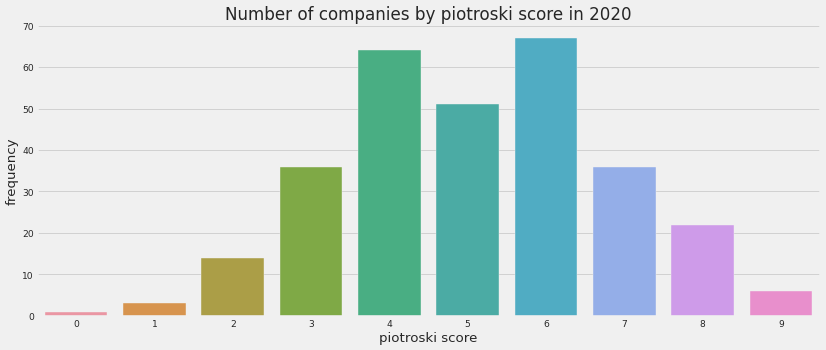

In [19]:
fscore_count = score_2020['score'].value_counts()

fig, ax = plt.subplots()

ax = sns.barplot(fscore_count.index, fscore_count)
ax.set_title('Number of companies by piotroski score in 2020')
ax.set_xlabel('piotroski score', fontsize = 16)
ax.set_ylabel('frequency', fontsize = 16)

plt.show()

### Top companies with highest piotroski score in 2020

In [20]:
top_companies = piotroski_score_all.loc[idx['2020',:],:] \
    [piotroski_score_all.loc[idx['2020',:],:].score == 9].reset_index().symbol.unique().tolist()

In [21]:
security_list.loc[top_companies]

,display_name,stock_name
symbol,,
000625.XSHE,长安汽车,CAQC
002456.XSHE,欧菲光,OFG
002938.XSHE,鹏鼎控股,PDKG
300498.XSHE,温氏股份,WSGF
600027.XSHG,华电国际,HDGJ
601808.XSHG,中海油服,ZHYF


Let me know how to display chinese names on the plots

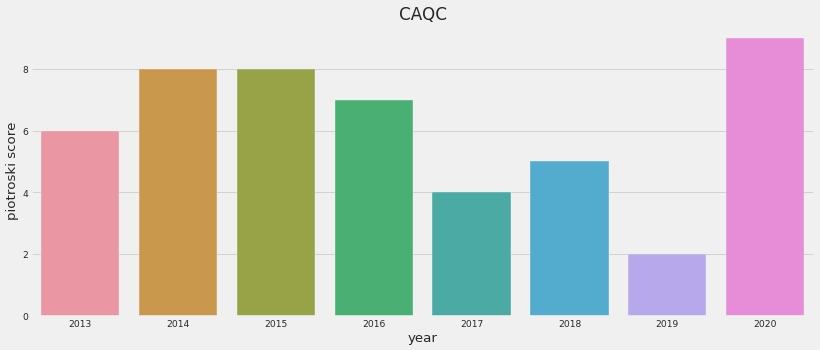

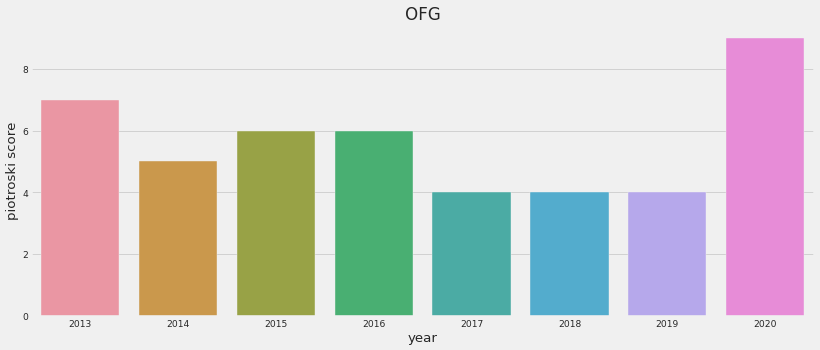

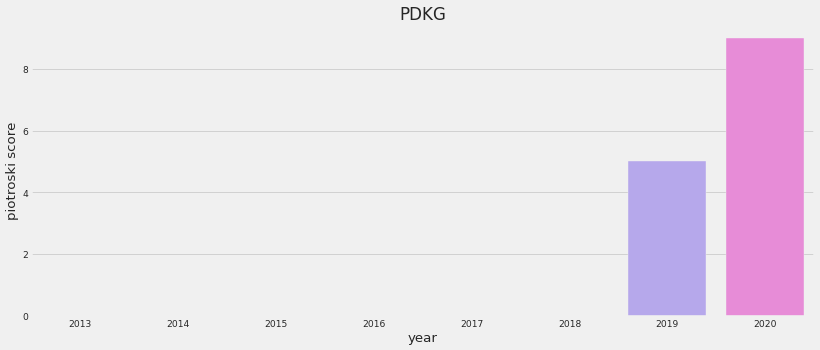

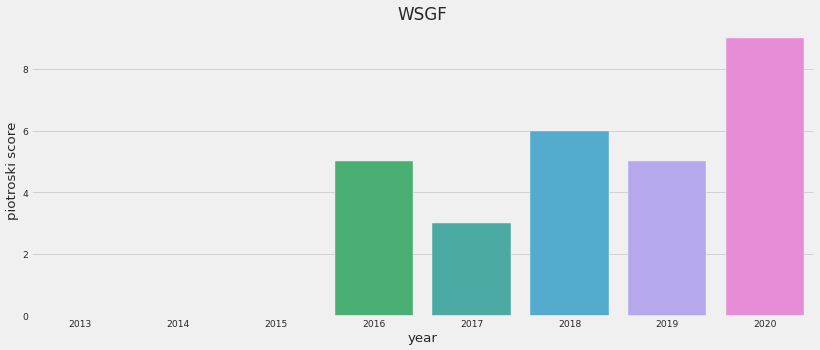

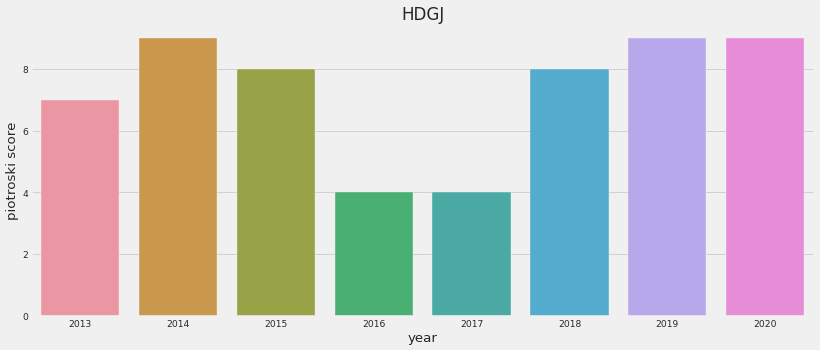

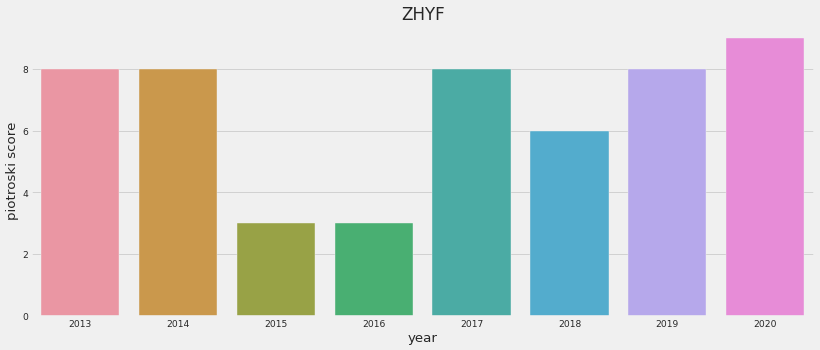

In [22]:
for company in top_companies:
    barplot_score(company)

Cumulative price returns in 2020

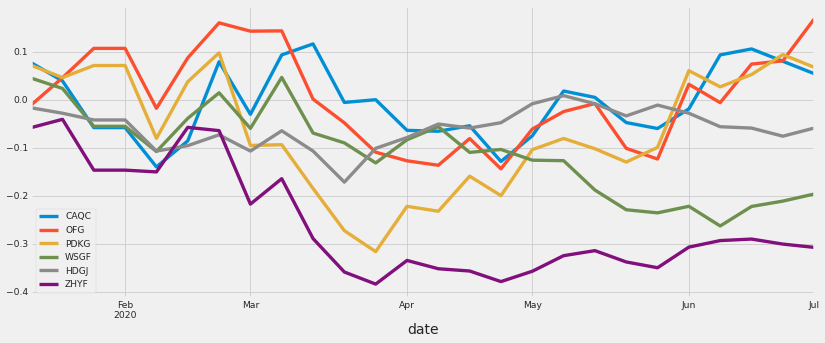

In [23]:
plot_cum_returns(top_companies)

### Top companies with highest average piotroski score

In [24]:
top_companies_avgscore = piotroski_score_all.loc[idx[:,:],:].reset_index().groupby('symbol')['score'].mean()
top_companies_avgscore = top_companies_avgscore.sort_values(ascending=False)

In [25]:
security_list.loc[top_companies_avgscore.head(5).index.tolist()]

,display_name,stock_name
symbol,,
600585.XSHG,海螺水泥,HLSN
600900.XSHG,长江电力,CJDL
601006.XSHG,大秦铁路,DQTL
000860.XSHE,顺鑫农业,SXNY
600027.XSHG,华电国际,HDGJ


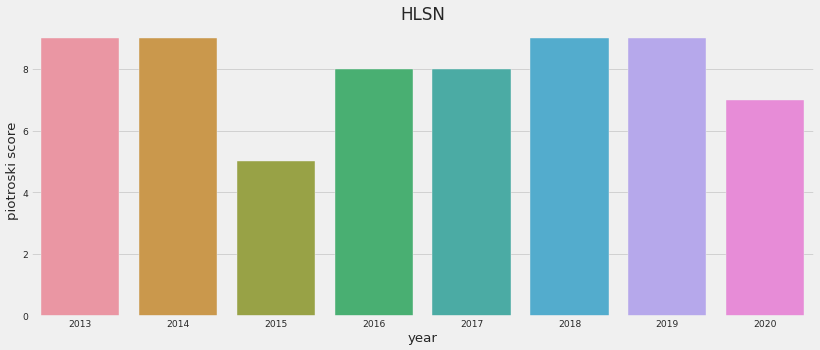

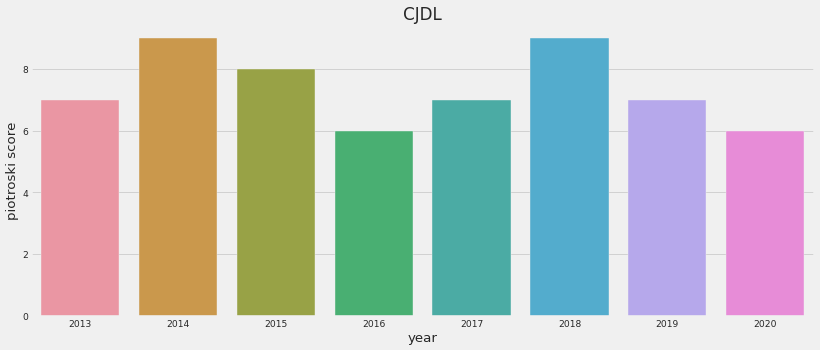

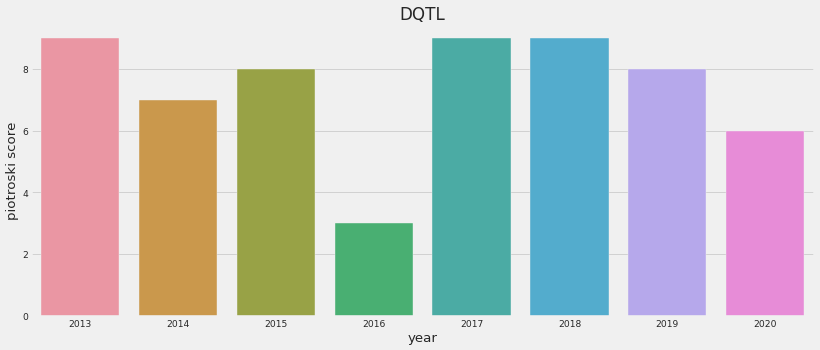

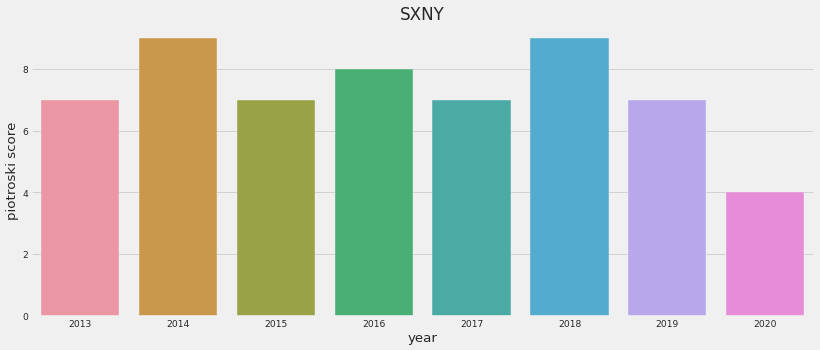

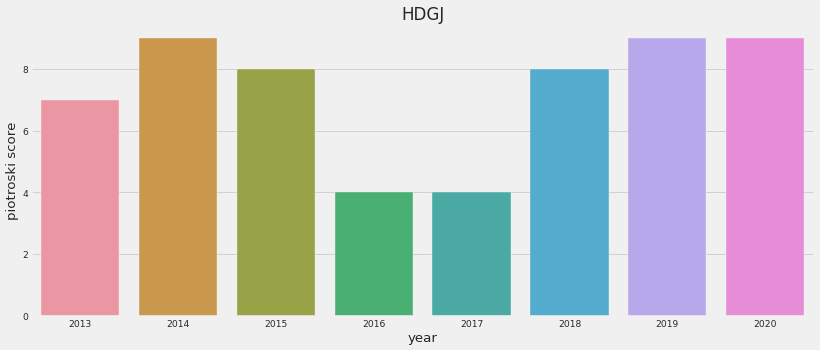

In [26]:
for company in top_companies_avgscore.head(5).index.tolist():
    barplot_score(company)

Cumulative price returns in 2020

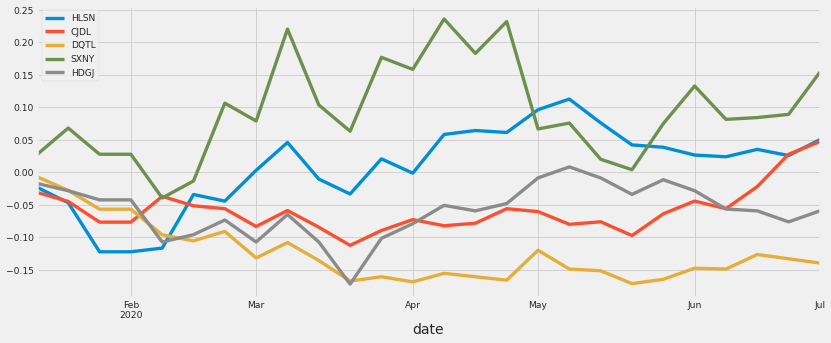

In [27]:
plot_cum_returns(top_companies_avgscore.head(5).index.tolist())

Good Piotroski Scores do not necessarily translate to better stock price returns.  It is possible that these companies are already fairly valued, widely analysed and covered.  Nevertheless, it is worth keeping a closer watch on these companies and buy when prices are attractive.